In [263]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pytesseract
from shapely import LineString, Point, Polygon, box

# Importar datos desde csv

In [264]:
data_segmentos = '../01_ingest_labeled_data/output_csv/data_segments.csv'
data_imagenes = '../01_ingest_labeled_data/output_csv/data_images.csv'
df_segmentos = pd.read_csv(data_segmentos).drop(columns=['Unnamed: 0'])
df_imagenes = pd.read_csv(data_imagenes).drop(columns=['Unnamed: 0'])

In [265]:
df_segmentos.head()

,file,x_1,y_1,x_2,y_2,label,content
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender..."


In [266]:
df_imagenes.head()

,file,bitmap,height,width
0,Crónica 1983-12-14 General Weher Justifico tod...,[[[255 255 255]\n [255 255 255]\n [255 255 2...,971.0,1672.0
1,La Razon 1986-12-05 Los senadores de la Renova...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...,1009.0,1202.0
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,[[[255 255 255]\n [255 255 255]\n [255 255 2...,252.0,945.0


In [267]:
articulo = df_imagenes.iloc[2]
articulo

file      La Gaceta de hoy 1986-12-24 Arosa descartó un ...
bitmap    [[[255 255 255]\n  [255 255 255]\n  [255 255 2...
height                                                252.0
width                                                 945.0
Name: 2, dtype: object

In [268]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']]
segmentos_articulo

,file,x_1,y_1,x_2,y_2,label,content
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender..."
5,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,162,936,227,Cuerpo,"El ministro del Interior, Antonio Tróccoli, so..."


# Obtener tokens

In [351]:
path_images = '../01_ingest_labeled_data/iaxidentidad_tif'

In [352]:
mi_cfg = r"-l spa --psm 3 --oem 3"

In [353]:
#cajas = pytesseract.image_to_boxes(imagen_cv, config=mi_cfg)

In [354]:
df_tokens = pytesseract.image_to_data(path_images + '/' + articulo['file'], config=mi_cfg, output_type=pytesseract.Output.DATAFRAME)

In [355]:
df_tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   level      309 non-null    int64  
 1   page_num   309 non-null    int64  
 2   block_num  309 non-null    int64  
 3   par_num    309 non-null    int64  
 4   line_num   309 non-null    int64  
 5   word_num   309 non-null    int64  
 6   left       309 non-null    int64  
 7   top        309 non-null    int64  
 8   width      309 non-null    int64  
 9   height     309 non-null    int64  
 10  conf       309 non-null    float64
 11  text       254 non-null    object 
dtypes: float64(1), int64(10), object(1)
memory usage: 29.1+ KB


## Limpieza

In [356]:
def confidence_filter(df_data, confianza_min):
    """Devuelve df con palabras que superan X umbral de confianza en la detección. Parámetros: df original y confianza mínima."""
    mask_conf = (df_data['conf'].astype('float') > confianza_min)
    print('Eliminados ', df_data[~mask_conf].shape[0])
    print(df_data[~mask_conf])
    return df_data[mask_conf]

def blank_filter(df_data):
    """Devuelve df sin elementos que fueron detectados como espacios. Parámetro: df original."""    
    mask_not_blank = (df_data['text'].str.strip() != '') & (df_data['text'] != np.NaN)
    print('Eliminados ', df_data[~mask_not_blank].shape[0])
    print(df_data[~mask_not_blank])
    return df_data[mask_not_blank]

def height_filter(df_data):
    """Devuelve df sin outliers detectados en función de la altura del elemento. Parámetro: df original."""    
    highThresh_h = round(df_data['height'].quantile(.90) * 6)
    lowThresh_h = round(df_data['height'].quantile(.90) / 5)
    mask_height = (df_data['height'] > lowThresh_h) & (df_data['height'] < highThresh_h)
    print('Eliminados ', df_data[~mask_height].shape[0])
    print(df_data[~mask_height])
    return df_data[mask_height]

In [357]:
df_tokens = confidence_filter(df_tokens, 20)

Eliminados  76
     level  page_num  block_num  par_num  line_num  word_num  left  top  \
0        1         1          0        0         0         0     0    0   
1        2         1          1        0         0         0    15   21   
2        3         1          1        1         0         0    15   21   
3        4         1          1        1         1         0    15   21   
9        2         1          2        0         0         0    18   95   
..     ...       ...        ...      ...       ...       ...   ...  ...   
293      4         1          8        1         1         0   642  201   
303      5         1          8        1         1        10   904  209   
304      4         1          8        1         2         0   642  206   
307      5         1          8        1         2         3   808  207   
308      5         1          8        1         2         4   854  206   

     width  height       conf text  
0      945     252  -1.000000  NaN  
1      843

In [358]:
df_tokens = blank_filter(df_tokens)

Eliminados  1
     level  page_num  block_num  par_num  line_num  word_num  left  top  \
121      5         1          3        1         1         1   113  157   

     width  height  conf text  
121      5       9  95.0       


## Generar poligonos de bounding boxes a partir de coordenadas

In [359]:
def get_polygons_from_xywh(row):
    p1 = Point(row['left'], row['top'])
    p2 = Point(row['left']+row['width'], row['top'])
    p3 = Point(row['left']+row['width'], row['top']+row['height'])
    p4 = Point(row['left'], row['top']+row['height'])
    p_list = [p1, p2, p3, p4]
    row['poligono'] = box([p.x, p.y] for p in p_list)
    return row

def get_polygons_from_xyxy(row):
    p1 = Point(row['x_1'], row['y_1'])
    p2 = Point(row['x_2'], row['y_1'])
    p3 = Point(row['x_2'], row['y_2'])
    p4 = Point(row['x_1'], row['y_2'])
    p_list = [p1, p2, p3, p4]
    row['poligono'] = box([p.x, p.y] for p in p_list)
    return row

In [374]:
df_tokens['poligono'] = df_tokens.apply(lambda row: box(row.left, row.top, row.left + row.width, row.top + row.height), axis=1)
df_tokens

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,poligono,label
4,5,1,1,1,1,1,15,28,156,50,96.395561,AROSA,"POLYGON ((171 28, 171 78, 15 78, 15 28, 171 28))",Título
5,5,1,1,1,1,2,186,24,231,50,96.835632,DESCARTO,"POLYGON ((417 24, 417 74, 186 74, 186 24, 417 ...",Título
6,5,1,1,1,1,3,433,23,65,48,96.850578,UN,"POLYGON ((498 23, 498 71, 433 71, 433 23, 498 ...",Título
7,5,1,1,1,1,4,514,21,143,48,96.918533,GOLPE,"POLYGON ((657 21, 657 69, 514 69, 514 21, 657 ...",Título
8,5,1,1,1,1,5,670,22,188,47,96.896133,MILITAR,"POLYGON ((858 22, 858 69, 670 69, 670 22, 858 ...",Título
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,5,1,8,1,1,7,801,205,47,9,85.354744,denuncia,"POLYGON ((848 205, 848 214, 801 214, 801 205, ...",Cuerpo
301,5,1,8,1,1,8,852,197,13,23,97.002762,de,"POLYGON ((865 197, 865 220, 852 220, 852 197, ...",Cuerpo
302,5,1,8,1,1,9,870,209,6,6,59.142704,ay,"POLYGON ((876 209, 876 215, 870 215, 870 209, ...",Cuerpo
305,5,1,8,1,2,1,642,216,14,6,38.082321,Sin,"POLYGON ((656 216, 656 222, 642 222, 642 216, ...",Cuerpo


In [375]:
df_segmentos['poligono'] = df_segmentos.apply(lambda row: box(row.x_1, row.y_1, row.x_2, row.y_2), axis=1)
df_segmentos

,file,x_1,y_1,x_2,y_2,label,content,poligono
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR,"POLYGON ((863 19, 863 78, 12 78, 12 19, 863 19))"
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI,"POLYGON ((761 144, 761 159, 642 159, 642 144, ..."
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...,"POLYGON ((309 92, 309 229, 14 229, 14 92, 309 ..."
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ...","POLYGON ((623 90, 623 228, 323 228, 323 90, 62..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender...","POLYGON ((932 90, 932 142, 641 142, 641 90, 93..."
...,...,...,...,...,...,...,...,...
182,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,95,417,419,894,Cuerpo,El doctor Julio Desiderio\nBurlando a cargo de...,"POLYGON ((419 417, 419 894, 95 894, 95 417, 41..."
183,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,446,417,764,892,Cuerpo,privación ilegítima de libertad\ny violación d...,"POLYGON ((764 417, 764 892, 446 892, 446 417, ..."
184,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,796,417,1122,892,Cuerpo,"Plata, y no lo habría denunciado\n.\nEl magist...","POLYGON ((1122 417, 1122 892, 796 892, 796 417..."
185,Tiempo Argentino 1986-01-10 Querella del ex......,71,9,640,146,Título,"Querella del ex oficial\nHours por ""injurias""","POLYGON ((640 9, 640 146, 71 146, 71 9, 640 9))"


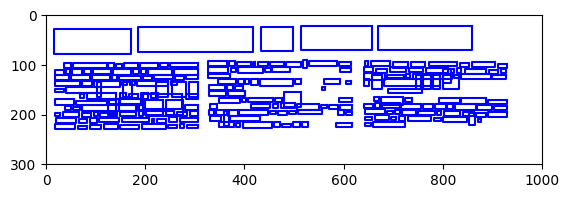

In [379]:
# Obtener las coordenadas de los vértices de cada objeto
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
for r in df_tokens['poligono']:
    r_coords = list(r.exterior.coords)

    ax.plot(*zip(*r_coords), color='b')
    # Dibujar los objetos en un gráfico
plt.axis([0, 1000, 300, 0])
plt.show()

## Obtener etiqueta de tokens a partir de etiquetado manual

In [363]:
def get_label_token(poligono_token, segmentos_articulo):
    #segmentos_articulo = df_segmentos[df_segmentos['file']==file][['poligono', 'label']]
    #print(segmentos_articulo.shape)
    #etiqueta = np.nan
    label_candidates = {'etiqueta': -1, 'perc': -1}
    i=0
    for _, segmento in segmentos_articulo.iterrows():
        #print('Poligono token: ')
        #display(poligono_token)
        #print('Poligono segmento: ')
        #display(_, segmento['poligono'])
        if poligono_token.intersects(segmento['poligono']):
            i+=1
            perc = (poligono_token.intersection(segmento['poligono']).area / poligono_token.union(segmento['poligono']).area)*100
            #print ('(label_candidates[perc]', label_candidates['perc'])
            #print('new perc', perc)
            if (label_candidates['perc'] < perc):
                label_candidates = {'etiqueta': segmento['label'], 'perc': perc}
                #print(i)
    
    return label_candidates['etiqueta']

In [364]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']][['poligono', 'label']]
df_tokens['label'] = df_tokens['poligono'].apply(lambda x: get_label_token(x, segmentos_articulo))

In [365]:
df_tokens

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,poligono,label
4,5,1,1,1,1,1,15,28,156,50,96.395561,AROSA,"POLYGON ((171 28, 171 78, 15 78, 15 28, 171 28))",Título
5,5,1,1,1,1,2,186,24,231,50,96.835632,DESCARTO,"POLYGON ((417 24, 417 74, 186 74, 186 24, 417 ...",Título
6,5,1,1,1,1,3,433,23,65,48,96.850578,UN,"POLYGON ((498 23, 498 71, 433 71, 433 23, 498 ...",Título
7,5,1,1,1,1,4,514,21,143,48,96.918533,GOLPE,"POLYGON ((657 21, 657 69, 514 69, 514 21, 657 ...",Título
8,5,1,1,1,1,5,670,22,188,47,96.896133,MILITAR,"POLYGON ((858 22, 858 69, 670 69, 670 22, 858 ...",Título
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,5,1,8,1,1,7,801,205,47,9,85.354744,denuncia,"POLYGON ((848 205, 848 214, 801 214, 801 205, ...",Cuerpo
301,5,1,8,1,1,8,852,197,13,23,97.002762,de,"POLYGON ((865 197, 865 220, 852 220, 852 197, ...",Cuerpo
302,5,1,8,1,1,9,870,209,6,6,59.142704,ay,"POLYGON ((876 209, 876 215, 870 215, 870 209, ...",Cuerpo
305,5,1,8,1,2,1,642,216,14,6,38.082321,Sin,"POLYGON ((656 216, 656 222, 642 222, 642 216, ...",Cuerpo


## Debug

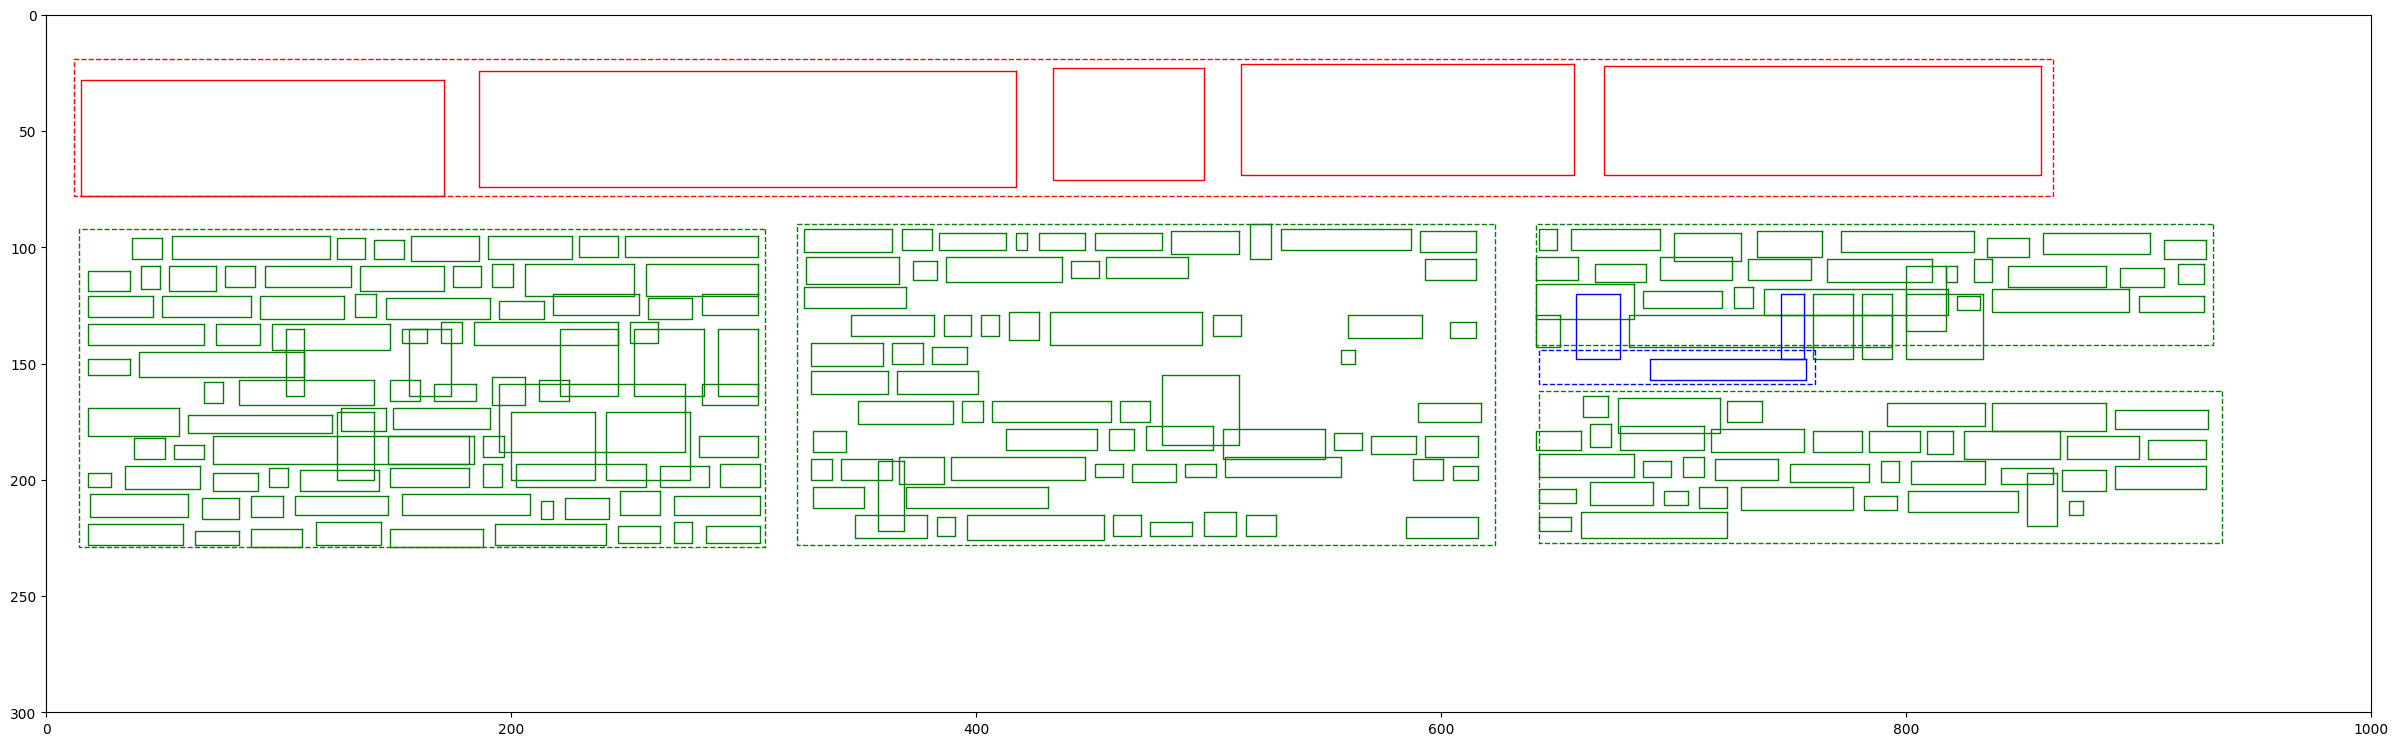

In [408]:
# Obtener las coordenadas de los vértices de cada objeto
colors = {'Título': 'r', 'Cuerpo': 'g', 'Destacado':'b'}
plt.rcParams['figure.figsize'] = [30, 30]
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
for l in df_tokens['label'].value_counts().keys().to_list():
    for r in df_tokens[df_tokens['label']==l]['poligono']:
        r_coords = list(r.exterior.coords)

        ax.plot(*zip(*r_coords), color=colors[l], linewidth=1, fillstyle='full')
        # Dibujar los objetos en un gráfico
    for r in segmentos_articulo[segmentos_articulo['label']==l]['poligono']:
        r_coords = list(r.exterior.coords)

        ax.plot(*zip(*r_coords), color=colors[l], linewidth=1, linestyle='--')
        # Dibujar los objetos en un gráfico
plt.axis([0, 1000, 300, 0])
plt.show()